In [1]:
from IPython.core.display import display, HTML
import warnings
display(HTML("<style>.container { width:100% !important; }</style>"))
warnings.simplefilter("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import t

# Bayesian Optimization

This notebook demonstrates the basic principles of [Bayesian Optimization (BO)](https://en.wikipedia.org/wiki/Bayesian_optimization) and how to use MLOS to perform BO.

## Motivation

In software performance engineering, the impact different (input) parameters (e.g. buffer size, worker thread count, etc.) can have on the (output) performance of a system for a given workload (input) can be modeled as a multidimensional function - one which we don't know the equation for apriori, but are instead trying to learn through careful sampling of the input space and experimentation (test/benchmark runs) to gather output points.
Bayesian optimization is one technique for efficiently selecting the samples in the input space to learn the approximate shape of that function and find its optimum, i.,e. the parameters that lead to the best performance.
In this example we use a synthetic (i.e. made-up) function that we can look at directly to stand in for a complex system with unknown characteristics.

Bayesian Optimization is a [global optimization](https://en.wikipedia.org/wiki/Global_optimization) strategy, so a way to find the global optimum of a mathematical function that's not necessarily [convex](https://en.wikipedia.org/wiki/Convex_function). BO is a black-box optimization technique, meaning that it requires only function values and no other information like gradients.

This is in contrast to other optimization strategies, such as gradient descent or conjugate gradient that require gradients and are only guaranteed to find a local optimum (if the function is assumed to be convex, this is also the global optimum).

Finding the global optimum of a general non-convex function is NP-hard, which makes it impossible to provide effective convergence guarantees for any global optimization strategy, including Bayesian Optimization. However, BO has been found to be quite effective in the past.

## A synthetic example

Let's take a simple synthetic example of a one-dimensional function that we assume is unknown.
If we actually had access to the function, we could use more efficient techniques using calculus and would not be using Bayesian Optimization.

In [3]:
# In an actual application, we would not have access to this function directly.
# Instead, we could only measure the outcome by running an experiment, such as timing
# a particular run of the system.
def f(x):
    return -(6*x-2)**2*np.sin(12*x-4)

In a real use case for global optimization, the function we want to optimize is usually only implicitly defined and very expensive to compute, such as training and evaluating a neural network, or timing the run of a large workload on a distributed database. Given the cost of evaluating the function, our goal is to find an optimum while keeping the number of function evaluations to a minimum.

In this synthetic example, we actually know the function, so we can just plot it for illustration purposes:

Text(0, 0.5, 'Objective (i.e. performance)')

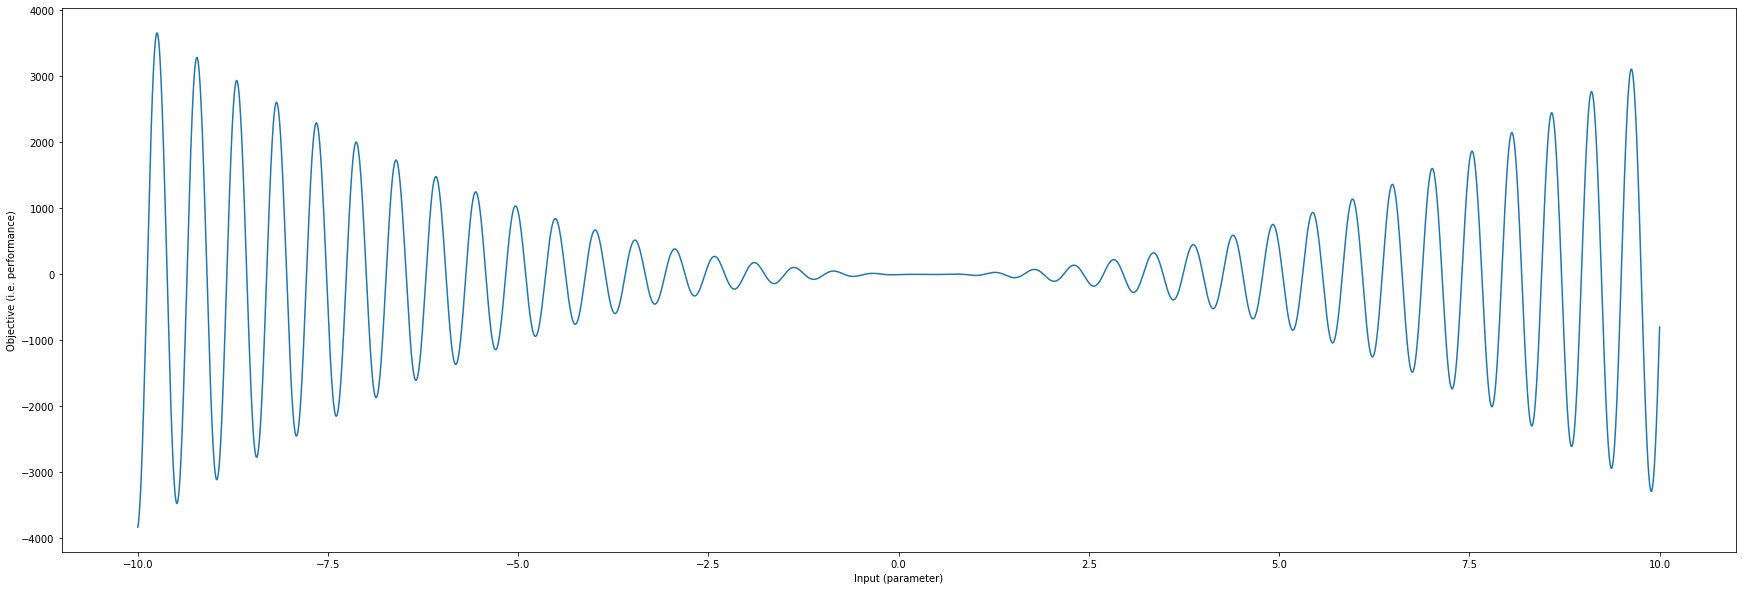

In [4]:
plt.figure(figsize=(30,10))
# define a domain to evaluate
line = np.linspace(-10, 10, 10000)
# evaluate function
values = f(line)
# plot function
plt.plot(line, values)
plt.xlabel("Input (parameter)")
plt.ylabel("Objective (i.e. performance)")

Our goal here is to find the global minimum of this function, assuming that we don't have direct access to the formula (given the formula, we could instead calculate the optimum quite precicely using methods from calculus instead). Usually, the function is too expensive to evaluate in such a manner, in particular in higher-dimensional spaces.

Now, we use MLOS to construct an OptimizationProblem object that will encapsulate the function and the input space.

In [5]:
from mlos.Optimizers.OptimizationProblem import OptimizationProblem, Objective
from mlos.Optimizers.BayesianOptimizer import BayesianOptimizer
from mlos.Spaces import SimpleHypergrid, ContinuousDimension


input_space = SimpleHypergrid(
    name="input",
    dimensions=[
        ContinuousDimension(name="x", min=-10, max=10)
    ]
)


output_space = SimpleHypergrid(
    name="objective",
    dimensions=[
        ContinuousDimension(name="function_value", min=-1000, max=1000)
    ]
)


optimization_problem = OptimizationProblem(
    parameter_space=input_space,
    objective_space=output_space,
    objectives=[Objective(name="function_value", minimize=False)]
)

The way Bayesian Optimization (in particular what is known as sequential model-based optimization) works is by iterating the following steps:
- Evaluate the function at a candidate point x_i (start with a random point x_0), observe f(x_i).
- Build / update a **surrogate model** g_i of the objective function (here a Random Forest) using the pairs x_i, f(x_i) that we observed so far.
- Pick the next data point to evaluate based on the updated model g_i using a criterion known as **acquisition function**.

The idea is that eventually the surrogate model will provide a good approximation of the objective function, but it will be much faster to evaluate (i.e. by predicting with a Random Forest or Gaussian process or another trained machine learning model, instead of running a complex deployment). The acquisition function serves as a means to trade off exploration vs exploitation in collecting new data for building the surrogate model: it picks points that have a low (close to optimum) value of the surrogate model (and so are expected to have a low value of the actual objective). This is the "exploitation" of existing knowledge in the model. On the other hand, it also encourages exploring new areas in which there is a lot of uncertainty in the surrogate model, i.e. where we expect the surrogate model not to be very acurate yet.

This process is coordinated by the ``BayesianOptimizer`` object, which we will use to perform Bayesian Optimization with a random forest surrogate model. Details of this particular method can be found in [Hutter et. al. (2011)](https://www.cs.ubc.ca/~hutter/papers/11-LION5-SMAC.pdf). We're first configuring the model to refit after every iteration and use 10 trees for the random forest:

In [6]:
from mlos.Optimizers.BayesianOptimizerConfigStore import bayesian_optimizer_config_store
from mlos.Optimizers.BayesianOptimizerFactory import BayesianOptimizerFactory
from mlos.Spaces import Point


# Let's adjust some parameters on the optimizer.
#
optimizer_config = bayesian_optimizer_config_store.default
optimizer_config.experiment_designer_config_fraction_random_suggestions = 0.1
optimizer_config.homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.n_new_samples_before_refit = 1
optimizer_config.homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator = .9

optimizer_factory = BayesianOptimizerFactory()

# Finally we get to create it!
#
optimizer = optimizer_factory.create_local_optimizer(
    optimization_problem=optimization_problem,
    optimizer_config=optimizer_config
)

10/01/2020 23:00:26 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 0.9,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_m

Now, we can run the actual optimization which will carry out the steps outlined above.

In [7]:
def run_optimization(optimizer):
    
    # SUGGEST
    #
    suggested_value = optimizer.suggest()
    input_values_df = suggested_value.to_dataframe()
    
    # EVALUATE
    #
    target_value = f(suggested_value['x'])
    target_values_df = pd.DataFrame({'function_value': [target_value]})
    
    # REGISTER
    #
    print(suggested_value, target_value)
    optimizer.register(input_values_df, target_values_df)

# Run for some iterations.
#
n_iterations = 25
for i in range(n_iterations):
    run_optimization(optimizer)

{"x": -9.660467078493442} 1864.2503662626807
{"x": 8.225494272678134} -991.7509155959091
{"x": 3.0098441998493985} -166.57390584058197
{"x": 3.684365603202135} -237.61707498490168
{"x": 9.677374937094957} 2590.71134167473
{"x": -7.963817197833334} -2037.5383234571946
{"x": 8.87609293954101} -2408.071444510895
{"x": -8.474533785671479} -2513.514055975679
{"x": -4.71841923930147} -736.8931109348543
{"x": -8.539975760020504} -930.3940635664717
{"x": -8.206462550523959} 2442.206137725168
{"x": -7.758455616843005} 669.3052071167874
{"x": -5.799009233328198} -1315.2194168072062
{"x": 4.273283913813215} 86.55862460306106
{"x": 9.729332291275778} 1075.915388640846
{"x": 9.978452054748107} -1598.2631678781431
{"x": 9.810193065308543} -1891.6822811289805
{"x": -9.488903728791547} -3467.4838554287057
{"x": 7.967686537717494} 1017.0553378318567
{"x": 5.83534793731979} 55.26121908887842
{"x": 8.938407301252418} -1066.6551439253378
{"x": -6.547162789669796} 1318.4792811724415
{"x": -8.18066110938452

You can see that the function value is not always increasing, and that is for two reasons: first, the optimizer keeps exploring parts of the space in which there is uncertainty. Second, by default the BayesianOptimizer picks a fraction of points at random to increase exploration. This fraction is set as ``optimizer_config.experiment_designer_config_fraction_random_suggestions = .1`` above.

After 25 iterations, the model is likely to have captured the general shape, but probably not have found the actual optimum:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001E9C729A9C8>],
      dtype=object)

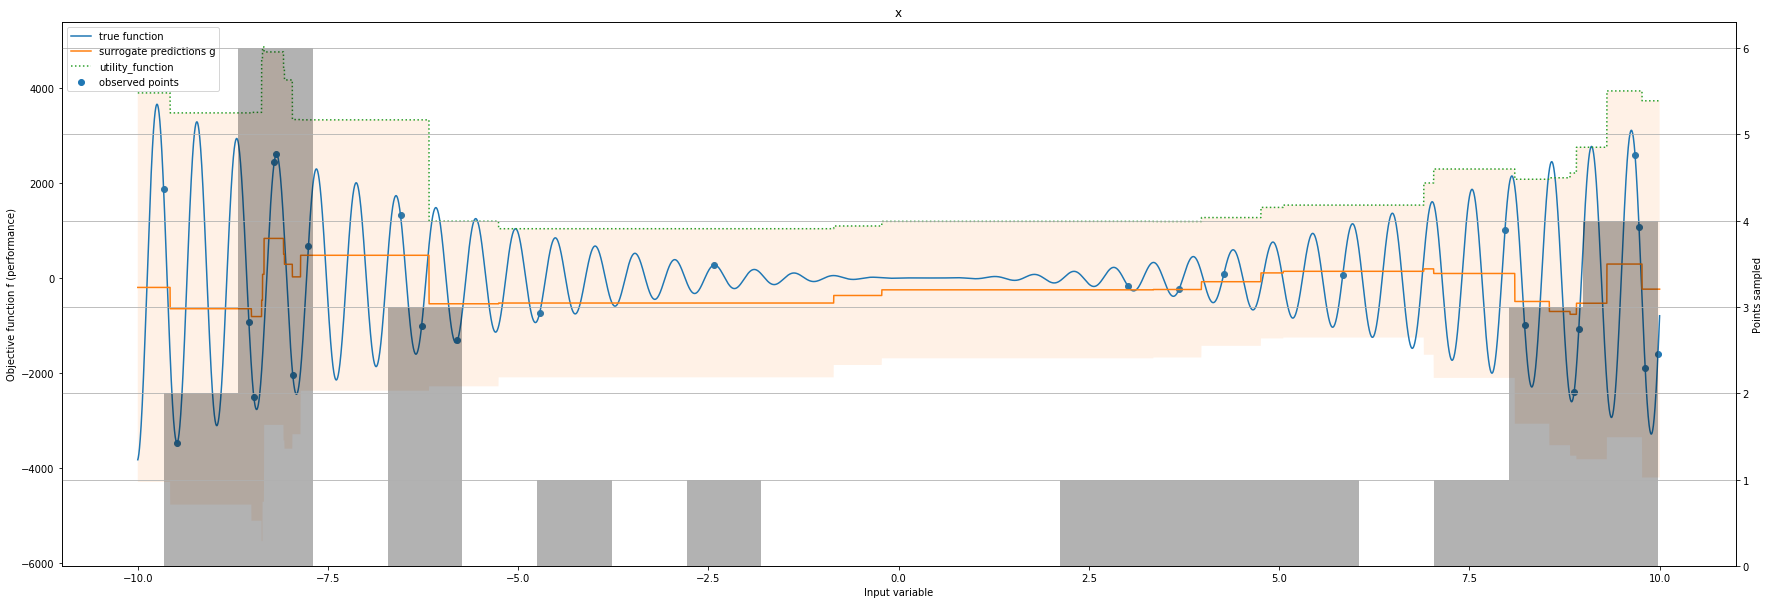

In [8]:
surrogate_predictions = optimizer.predict(pd.DataFrame({'x': line})).get_dataframe()
feature_values, target_values = optimizer.get_all_observations()

plt.figure(figsize=(30,10))
plt.scatter(feature_values, target_values, label='observed points')

# plot true function (usually unknown)
#
plt.plot(line, values, label='true function')

# plot the surrogate
#
alpha = optimizer_config.experiment_designer_config.confidence_bound_utility_function_config.alpha
t_values = t.ppf(1 - alpha / 2.0, surrogate_predictions['predicted_value_degrees_of_freedom'])
ci_radii = t_values * np.sqrt(surrogate_predictions['predicted_value_variance'])
value = surrogate_predictions['predicted_value']
plt.plot(line, value, label='surrogate predictions g')
plt.fill_between(line, value - ci_radii, value + ci_radii, alpha=.1)
plt.plot(line, optimizer.experiment_designer.utility_function(pd.DataFrame({'x': line})), ':', label='utility_function')
plt.ylabel("Objective function f (performance)")
plt.xlabel("Input variable")
plt.legend()

# Let's add a histogram to show the frequency with which we queried x's.
#
ax = plt.gca()
bins_axes = ax.twinx()
bins_axes.set_ylabel("Points sampled")
feature_values.hist(bins=20, ax=bins_axes, alpha=.3, color='k', label="count of querry points")

In [9]:
from mlos.Optimizers.OptimumDefinition import OptimumDefinition

# Let's plot some optima on top of this plot. Each definition of optimum has some important properties.
#

# BEST_OBSERVATION - is for those among us who don't care about noise.
#
best_config_point, best_objective = optimizer.optimum(optimum_definition=OptimumDefinition.BEST_OBSERVATION)

# PREDICTED_VALUE_FOR_OBSERVED_CONFIG - for those of us who care about average performance.
#
predicted_best_config, predicted_optimum = optimizer.optimum(OptimumDefinition.PREDICTED_VALUE_FOR_OBSERVED_CONFIG)

# UPPER_CONFIDENCE_BOUND_FOR_OBSERVED_CONFIG - for those of us who are feeling lucky.
#
ucb_99_ci_config, ucb_99_ci_optimum = optimizer.optimum(OptimumDefinition.UPPER_CONFIDENCE_BOUND_FOR_OBSERVED_CONFIG, alpha=0.01)

# LOWER_CONFIDENCE_BOUND_FOR_OBSERVED_CONFIG - for those of us who care about the P99.
#
lcb_99_ci_config, lcb_99_ci_optimum = optimizer.optimum(OptimumDefinition.LOWER_CONFIDENCE_BOUND_FOR_OBSERVED_CONFIG, alpha=0.01)

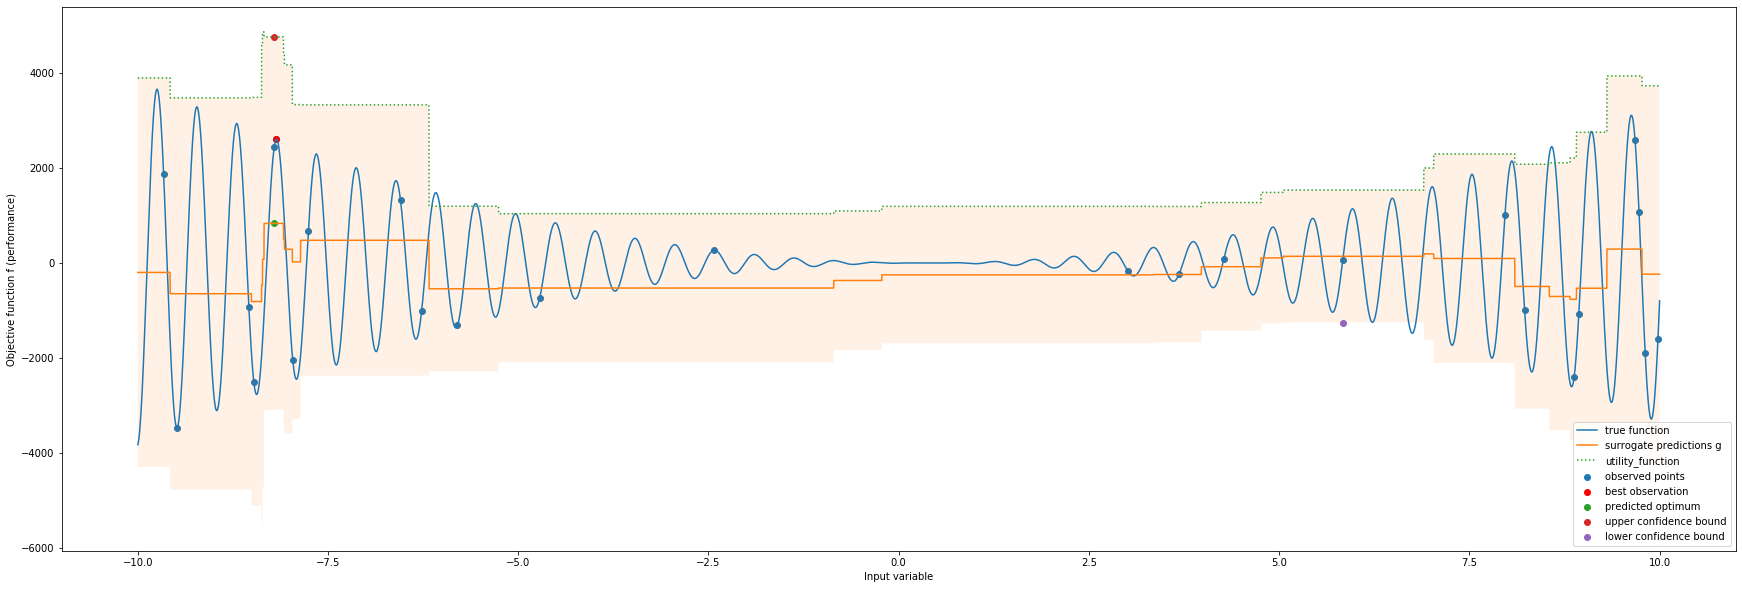

In [10]:
# Let's plot the same thing as above.
#
plt.figure(figsize=(30,10))
plt.scatter(feature_values, target_values, label='observed points')
plt.plot(line, values, label='true function')
plt.plot(line, value, label='surrogate predictions g')
plt.fill_between(line, value - ci_radii, value + ci_radii, alpha=.1)
plt.plot(line, optimizer.experiment_designer.utility_function(pd.DataFrame({'x': line})), ':', label='utility_function')

# Now let's overlay the various optima.
#
plt.scatter(best_config_point.x, best_objective.function_value, label='best observation', color='red')
plt.scatter(predicted_best_config.x, predicted_optimum.predicted_value, label='predicted optimum')
plt.scatter(ucb_99_ci_config.x, ucb_99_ci_optimum.upper_confidence_bound, label="upper confidence bound")
plt.scatter(lcb_99_ci_config.x, lcb_99_ci_optimum.lower_confidence_bound, label="lower confidence bound")

plt.ylabel("Objective function f (performance)")
plt.xlabel("Input variable")
plt.legend()

We can run more iterations to improve the surrogate model and the optimum that is found:

In [17]:
# run for more iterations
n_iterations = 100
for i in range(n_iterations):
    run_optimization(optimizer)

{"x": 9.505903870882072} 347.86763700889986
{"x": -6.806190466016506} -1380.1689995473646
{"x": -9.589458415612276} -1071.2535870495678
{"x": -9.81059124076311} 2644.4641792737443
{"x": -6.521740778734562} 926.3640242078794
{"x": -9.573626063835004} -1684.6801057051532
{"x": 5.814768707795837} -210.8854349927159
{"x": 7.923168598483063} -58.398354457753115
{"x": 6.722409697007606} -1403.8512646670179
{"x": 9.526201306658134} 1067.9502306393542
{"x": 8.470960011476482} 617.8153523932239
{"x": -5.0638831833789695} 979.988042523906
{"x": 2.3084705881958776} 139.07376396596212
{"x": 5.1637047508788} -829.8987015726219
{"x": -8.105316780892524} 1714.9915626658785
{"x": 9.788943414342235} -1163.8908832848913
{"x": 5.229952940514831} -692.3580860017754
{"x": 9.787985464751433} -1129.0893244374292
{"x": -7.857898646453608} -1900.1971152213366
{"x": -8.090819520687605} 1354.6202078280937
{"x": -1.241715648532253} 4.555578304151065
{"x": -8.34531685535289} -1231.0014781435282
{"x": -8.1068819678

We can now visualize the surrogate model and optimization process again. The points are colored according to the iteration number, with dark blue points being early in the process and yellow points being later. You can see that at the end of the optimization, the points start to cluster around the optimum.

In [18]:
from mlos.Optimizers.OptimumDefinition import OptimumDefinition

# Let's plot some optima on top of this plot. Each definition of optimum has some important properties.
#

# BEST_OBSERVATION - is for those among us who don't care about noise.
#
best_config_point, best_objective = optimizer.optimum(optimum_definition=OptimumDefinition.BEST_OBSERVATION)

# PREDICTED_VALUE_FOR_OBSERVED_CONFIG - for those of us who care about average performance.
#
predicted_best_config, predicted_optimum = optimizer.optimum(OptimumDefinition.PREDICTED_VALUE_FOR_OBSERVED_CONFIG)

# UPPER_CONFIDENCE_BOUND_FOR_OBSERVED_CONFIG - for those of us who are feeling lucky.
#
ucb_99_ci_config, ucb_99_ci_optimum = optimizer.optimum(OptimumDefinition.UPPER_CONFIDENCE_BOUND_FOR_OBSERVED_CONFIG, alpha=0.01)

# LOWER_CONFIDENCE_BOUND_FOR_OBSERVED_CONFIG - for those of us who care about the P99.
#
lcb_99_ci_config, lcb_99_ci_optimum = optimizer.optimum(OptimumDefinition.LOWER_CONFIDENCE_BOUND_FOR_OBSERVED_CONFIG, alpha=0.01)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001E9C9488548>],
      dtype=object)

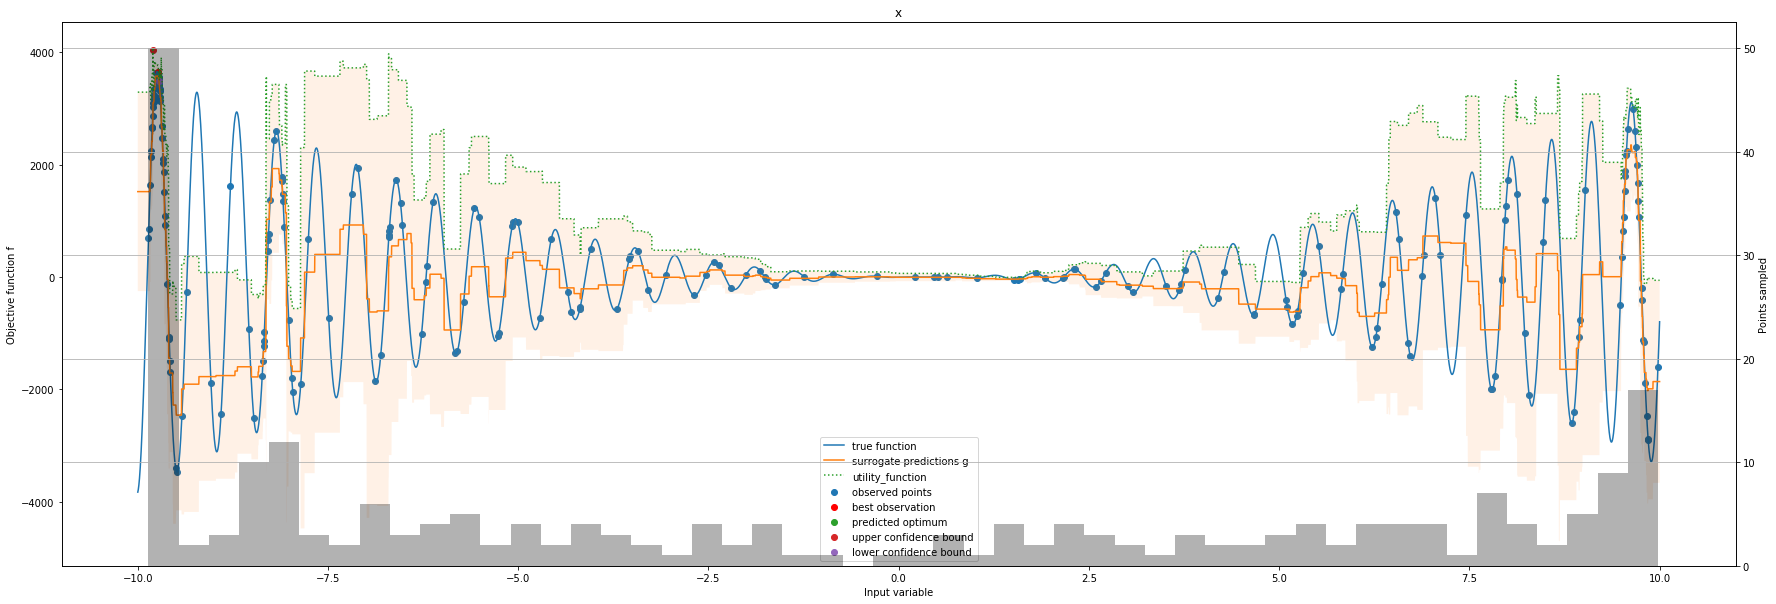

In [19]:
plt.figure(figsize=(30,10))
surrogate_predictions = optimizer.predict(pd.DataFrame({'x': line})).get_dataframe()
feature_values, target_values = optimizer.get_all_observations()
plt.scatter(feature_values, target_values, label='observed points')
plt.plot(line, values, label='true function')
alpha = optimizer_config.experiment_designer_config.confidence_bound_utility_function_config.alpha
t_values = t.ppf(1 - alpha / 2.0, surrogate_predictions['predicted_value_degrees_of_freedom'])
ci_radii = t_values * np.sqrt(surrogate_predictions['predicted_value_variance'])
value = surrogate_predictions['predicted_value']
plt.plot(line, value, label='surrogate predictions g')
plt.fill_between(line, value - ci_radii, value + ci_radii, alpha=.1)

# Now let's overlay the various optima.
#
plt.scatter(best_config_point.x, best_objective.function_value, label='best observation', color='red')
plt.scatter(predicted_best_config.x, predicted_optimum.predicted_value, label='predicted optimum')
plt.scatter(ucb_99_ci_config.x, ucb_99_ci_optimum.upper_confidence_bound, label="upper confidence bound")
plt.scatter(lcb_99_ci_config.x, lcb_99_ci_optimum.lower_confidence_bound, label="lower confidence bound")

plt.plot(line, optimizer.experiment_designer.utility_function(pd.DataFrame({'x': line})), ':', label='utility_function')
plt.legend()

ax = plt.gca()
ax.set_ylabel("Objective function f")
ax.set_xlabel("Input variable")


# Let's add a histogram to show the frequency with which we queried x's.
#
bins_axes = ax.twinx()
bins_axes.set_ylabel("Points sampled")
feature_values.hist(bins=50, ax=bins_axes, alpha=.3, color='k', label="count of querry points")

# Going further:

1) Plot the optimum as a function of iterations. How long does it take for the optimization to converge? Is that stable over several random restarts?

2) Does changing the search to a purely random search (setting ``optimizer_config.experiment_designer_config_fraction_random_suggestions = 1``) change how long the optimization takes to find the optimum?